In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as Scheduler
import torchvision.transforms as transforms
import sys
import torch.nn.init as init

In [13]:
# Basic neural net block - 2 3x3 convs with batch normalization and ReLU and then maxpool
class Basic(nn.Module):
    def __init__(self, indepth, outdepth, stride=1, padding=1):
        super(Basic, self).__init__()
        
        self.conv1 = nn.Conv2d(indepth, outdepth, kernel_size=3, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(outdepth)
        self.conv2 = nn.Conv2d(outdepth, outdepth, kernel_size=3, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(outdepth)
        init.xavier_normal(self.conv1.weight)
        init.constant(self.conv1.bias, 0.1)
        init.xavier_normal(self.conv2.weight)
        init.constant(self.conv2.bias, 0.1)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2, stride=2)
        return out
    
class Basic1(nn.Module):
    def __init__(self, indepth, outdepth, stride=1, padding=1):
        super(Basic1, self).__init__()
        
        self.conv1 = nn.Conv2d(indepth, outdepth, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(outdepth)
        self.conv2 = nn.Conv2d(outdepth, outdepth, kernel_size=3, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(outdepth)
        self.conv3 = nn.Conv2d(outdepth, outdepth, kernel_size=1, stride=stride, padding=0)
        self.bn3 = nn.BatchNorm2d(outdepth)
        init.xavier_normal(self.conv1.weight)
        init.constant(self.conv1.bias, 0.1)
        init.xavier_normal(self.conv2.weight)
        init.constant(self.conv2.bias, 0.1)
        init.xavier_normal(self.conv3.weight)
        init.constant(self.conv3.bias, 0.1)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.max_pool2d(out, 2, stride=2)
        return out
    
class BasicNet(nn.Module):
    def __init__(self, block=Basic, blocks=[1,1,1], strides=[1,1,1], imagedepth=3, startoutputdepth=64, classnums=10):
        super(BasicNet, self).__init__()
        self.imagedepth = imagedepth
        self.outdepth = startoutputdepth
        layers = []
        for i in range(len(blocks)):
            layer = block(self.imagedepth, self.outdepth, strides[i])
            layers.append(layer)
            self.imagedepth = self.outdepth
            self.outdepth = self.outdepth*2
        self.outdepth /= 2 #undoing last multiplication
        self.alllayers = nn.Sequential(*layers)
        self.linearlayer = nn.Sequential(nn.Linear(int(self.outdepth)*16, classnums),
                                         nn.Softmax())
    def forward(self, x):
        out = self.alllayers(x)
        out = out.view(-1, int(self.outdepth)*16)
        #print(out.size()[1]*out.size()[2]*out.size()[3])
        out = self.linearlayer(out)
        return out

In [14]:
class DataReading():
    def __init__(self):
        transform = transforms.Compose(
            [transforms.RandomCrop(32, padding=4), 
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                                download=True, transform=transform)
        valset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                                download=True, transform=transform)
        trainSampler, valSampler = self.validationSplit(trainset)
        self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, sampler=trainSampler, num_workers=2)
        self.valloader = torch.utils.data.DataLoader(valset, batch_size=256, sampler=valSampler, num_workers=2)
        testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                               download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                                 shuffle=False, num_workers=2)

        self.classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    def validationSplit(self, trainset, ratio=0.1, random_seed=42):
        trainlen = len(trainset)
        indices = list(range(trainlen))
        split = int(np.floor(ratio*trainlen))
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)    
        return train_sampler, valid_sampler

In [15]:
class ModelTrainer():
    def __init__(self, optimizer, errorfn, model):
        self.net = model
        self.net.cuda()
        if(optimizer==optim.SGD):
            self.optimizer = optimizer(self.net.parameters(), lr=0.01)
        else:
            self.optimizer = optimizer(self.net.parameters())
        self.scheduler = Scheduler.ReduceLROnPlateau(self.optimizer, patience=2, verbose=True)
        self.criterion = errorfn
        self.data = DataReading()
        
    def train(self):
        testLoss = []
        valLoss = []
        trainLoss = []
        testAcc = []
        valAcc = []
        trainAcc = []
        prevValLoss = sys.maxsize
        stopCount = 0
        stopEpochs = False
        for epoch in range(350):  # loop over the dataset multiple times
            running_loss = 0.0
            runcount = 0
            val_loss = 0.0
            valcount = 0
            test_loss = 0.0
            testcount = 0
            correct = 0
            total = 0
            for i, data in enumerate(self.data.trainloader, 0):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.data[0]
                runcount += 1

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()
        #     if(epoch%10==0):
            print('[%d] training loss: %.3f' %
                          (epoch + 1, running_loss / runcount))
            print('[%d] training accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            trainLoss.append(running_loss / runcount)
            trainAcc.append(100 * correct / total)
            correct = 0
            total = 0

            for i, data in enumerate(self.data.valloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.data[0]
                valcount += 1
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()
            valloss = val_loss/valcount
            self.scheduler.step(valloss)
            if(epoch>10 and prevValLoss<valloss):
                stopCount += 1
                if(stopCount>3):
                    stopEpochs = True
            elif(stopCount>0):
                stopCount = 0
            prevValLoss = valloss
        #     if(epoch%10==0):
            print('[%d] validation loss: %.3f' %
                          (epoch + 1, valloss))
            print('[%d] validation accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            valLoss.append(valloss)
            valAcc.append(100 * correct / total)
            correct = 0
            total = 0

            for i, data in enumerate(self.data.testloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.data[0]
                testcount += 1
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()

        #     if(epoch%10==0):
            print('[%d] test loss: %.3f' %
                          (epoch + 1, test_loss / testcount))
            print('[%d] test accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            testLoss.append(test_loss / testcount)
            testAcc.append(100 * correct / total)
            if(stopEpochs):
                break

        print('Finished Training')

        plt.title("Basic1 conv Net - 3 Layers, With Xavier, Data Augmentation")
        plt.plot(trainLoss, label="Train", color='blue')
        plt.plot(valLoss, label="Validation", color='green')
        plt.plot(testLoss, label="Test", color='red')
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()

        plt.title("Basic1 conv net - 3 Layers, With Xavier, Data Augmentation")
        plt.plot(trainAcc, label="Train", color='blue')
        plt.plot(valAcc, label="Validation", color='green')
        plt.plot(testAcc, label="Test", color='red')
        plt.ylabel("Accuracy")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()

In [30]:
model = ModelTrainer(optim.Adam, nn.CrossEntropyLoss(), BasicNet(block=Basic1))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


[1] training loss: 2.065
[1] training accuracy: 39.109
[1] validation loss: 2.000
[1] validation accuracy: 45.620
[1] test loss: 1.999
[1] test accuracy: 46.190
[2] training loss: 1.966
[2] training accuracy: 49.313
[2] validation loss: 1.943
[2] validation accuracy: 51.940
[2] test loss: 1.941
[2] test accuracy: 51.990
[3] training loss: 1.899
[3] training accuracy: 56.036
[3] validation loss: 1.866
[3] validation accuracy: 59.720
[3] test loss: 1.862
[3] test accuracy: 60.070
[4] training loss: 1.834
[4] training accuracy: 62.811
[4] validation loss: 1.826
[4] validation accuracy: 63.260
[4] test loss: 1.831
[4] test accuracy: 63.130
[5] training loss: 1.800
[5] training accuracy: 66.020
[5] validation loss: 1.788
[5] validation accuracy: 67.300
[5] test loss: 1.793
[5] test accuracy: 66.940
[6] training loss: 1.778
[6] training accuracy: 68.300
[6] validation loss: 1.770
[6] validation accuracy: 69.080
[6] test loss: 1.785
[6] test accuracy: 67.910
[7] training loss: 1.756
[7] train

[49] training loss: 1.576
[49] training accuracy: 88.656
[49] validation loss: 1.614
[49] validation accuracy: 84.700
[49] test loss: 1.616
[49] test accuracy: 84.730
[50] training loss: 1.578
[50] training accuracy: 88.482
Epoch    49: reducing learning rate of group 0 to 1.0000e-08.
[50] validation loss: 1.611
[50] validation accuracy: 85.280
[50] test loss: 1.614
[50] test accuracy: 84.700
[51] training loss: 1.576
[51] training accuracy: 88.740
[51] validation loss: 1.613
[51] validation accuracy: 84.920
[51] test loss: 1.619
[51] test accuracy: 84.510
[52] training loss: 1.577
[52] training accuracy: 88.602
[52] validation loss: 1.614
[52] validation accuracy: 84.740
[52] test loss: 1.613
[52] test accuracy: 84.800
[53] training loss: 1.577
[53] training accuracy: 88.604
[53] validation loss: 1.611
[53] validation accuracy: 85.200
[53] test loss: 1.620
[53] test accuracy: 84.150
[54] training loss: 1.575
[54] training accuracy: 88.800
[54] validation loss: 1.606
[54] validation ac

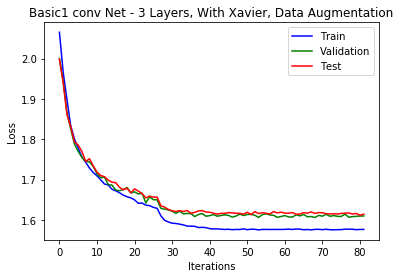

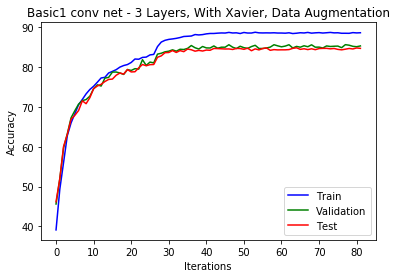

In [31]:
model.train()

In [16]:
model = ModelTrainer(optim.Adam, nn.CrossEntropyLoss(), BasicNet())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


[1] training loss: 2.013
[1] training accuracy: 44.538
[1] validation loss: 1.929
[1] validation accuracy: 53.160
[1] test loss: 1.922
[1] test accuracy: 53.970
[2] training loss: 1.883
[2] training accuracy: 57.762
[2] validation loss: 1.865
[2] validation accuracy: 59.340
[2] test loss: 1.872
[2] test accuracy: 58.970
[3] training loss: 1.818
[3] training accuracy: 64.416
[3] validation loss: 1.796
[3] validation accuracy: 66.400
[3] test loss: 1.793
[3] test accuracy: 66.850
[4] training loss: 1.777
[4] training accuracy: 68.318
[4] validation loss: 1.753
[4] validation accuracy: 70.780
[4] test loss: 1.758
[4] test accuracy: 70.550
[5] training loss: 1.746
[5] training accuracy: 71.660
[5] validation loss: 1.744
[5] validation accuracy: 71.740
[5] test loss: 1.744
[5] test accuracy: 71.610
[6] training loss: 1.729
[6] training accuracy: 73.196
[6] validation loss: 1.727
[6] validation accuracy: 73.380
[6] test loss: 1.725
[6] test accuracy: 73.650
[7] training loss: 1.715
[7] train

[49] test loss: 1.583
[49] test accuracy: 87.840
[50] training loss: 1.533
[50] training accuracy: 92.889
[50] validation loss: 1.580
[50] validation accuracy: 88.440
[50] test loss: 1.582
[50] test accuracy: 87.870
[51] training loss: 1.533
[51] training accuracy: 92.920
[51] validation loss: 1.579
[51] validation accuracy: 88.140
[51] test loss: 1.581
[51] test accuracy: 87.850
[52] training loss: 1.533
[52] training accuracy: 92.953
Epoch    51: reducing learning rate of group 0 to 1.0000e-07.
[52] validation loss: 1.580
[52] validation accuracy: 88.280
[52] test loss: 1.583
[52] test accuracy: 87.690
[53] training loss: 1.534
[53] training accuracy: 92.876
[53] validation loss: 1.584
[53] validation accuracy: 87.640
[53] test loss: 1.584
[53] test accuracy: 87.720
[54] training loss: 1.533
[54] training accuracy: 92.907
[54] validation loss: 1.576
[54] validation accuracy: 88.540
[54] test loss: 1.585
[54] test accuracy: 87.720
[55] training loss: 1.533
[55] training accuracy: 92.9

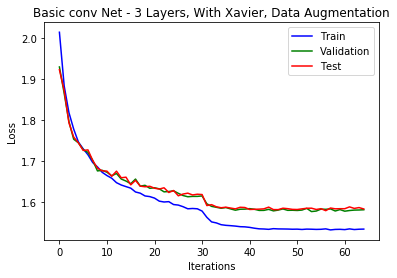

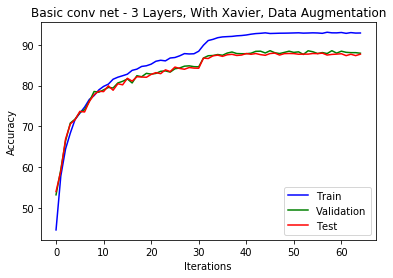

In [17]:
model.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[1] training loss: 2.095
[1] training accuracy: 35.940
[1] validation loss: 2.049
[1] validation accuracy: 40.600
[1] test loss: 2.046
[1] test accuracy: 41.140
[2] training loss: 2.012
[2] training accuracy: 44.520
[2] validation loss: 2.002
[2] validation accuracy: 45.660
[2] test loss: 1.993
[2] test accuracy: 46.670
[3] training loss: 1.976
[3] training accuracy: 48.256
[3] validation loss: 1.962
[3] validation accuracy: 49.880
[3] test loss: 1.971
[3] test accuracy: 49.020
[4] training loss: 1.952
[4] training accuracy: 50.616
[4] validation loss: 1.949
[4] validation accuracy: 50.680
[4] test loss: 1.948
[4] test accuracy: 51.000
[5] training loss: 1.919
[5] training accuracy: 53.944
[5] validation loss: 1.905
[5] validation accuracy: 55.440
[5] test loss: 1.912
[5] test accuracy: 55.310
[6] training loss: 1.875
[6] training accuracy: 58.296
[6] validation loss: 1.853

[49] validation loss: 1.580
[49] validation accuracy: 88.020
[49] test loss: 1.585
[49] test accuracy: 87.720
[50] training loss: 1.537
[50] training accuracy: 92.382
[50] validation loss: 1.578
[50] validation accuracy: 88.320
[50] test loss: 1.584
[50] test accuracy: 87.780
[51] training loss: 1.535
[51] training accuracy: 92.604
[51] validation loss: 1.579
[51] validation accuracy: 88.280
[51] test loss: 1.579
[51] test accuracy: 88.210
[52] training loss: 1.535
[52] training accuracy: 92.653
[52] validation loss: 1.579
[52] validation accuracy: 87.900
[52] test loss: 1.583
[52] test accuracy: 87.810
[53] training loss: 1.533
[53] training accuracy: 92.827
Epoch    52: reducing learning rate of group 0 to 1.0000e-05.
[53] validation loss: 1.579
[53] validation accuracy: 88.080
[53] test loss: 1.585
[53] test accuracy: 87.760
[54] training loss: 1.531
[54] training accuracy: 93.100
[54] validation loss: 1.575
[54] validation accuracy: 88.560
[54] test loss: 1.583
[54] test accuracy: 

[100] validation loss: 1.574
[100] validation accuracy: 88.660
[100] test loss: 1.578
[100] test accuracy: 88.360
[101] training loss: 1.529
[101] training accuracy: 93.231
[101] validation loss: 1.576
[101] validation accuracy: 88.540
[101] test loss: 1.583
[101] test accuracy: 87.980
[102] training loss: 1.528
[102] training accuracy: 93.340
[102] validation loss: 1.574
[102] validation accuracy: 88.620
[102] test loss: 1.580
[102] test accuracy: 88.290
[103] training loss: 1.529
[103] training accuracy: 93.282
[103] validation loss: 1.578
[103] validation accuracy: 88.320
[103] test loss: 1.580
[103] test accuracy: 88.260
[104] training loss: 1.530
[104] training accuracy: 93.136
[104] validation loss: 1.574
[104] validation accuracy: 88.620
[104] test loss: 1.578
[104] test accuracy: 88.530
[105] training loss: 1.529
[105] training accuracy: 93.304
[105] validation loss: 1.575
[105] validation accuracy: 88.820
[105] test loss: 1.579
[105] test accuracy: 88.170
[106] training loss: 

[147] test loss: 1.581
[147] test accuracy: 88.210
[148] training loss: 1.530
[148] training accuracy: 93.178
[148] validation loss: 1.580
[148] validation accuracy: 88.020
[148] test loss: 1.580
[148] test accuracy: 88.150
[149] training loss: 1.530
[149] training accuracy: 93.142
[149] validation loss: 1.578
[149] validation accuracy: 88.260
[149] test loss: 1.580
[149] test accuracy: 88.280
[150] training loss: 1.530
[150] training accuracy: 93.138
[150] validation loss: 1.582
[150] validation accuracy: 87.840
[150] test loss: 1.580
[150] test accuracy: 88.250
[151] training loss: 1.530
[151] training accuracy: 93.116
[151] validation loss: 1.575
[151] validation accuracy: 88.420
[151] test loss: 1.581
[151] test accuracy: 88.170
[152] training loss: 1.529
[152] training accuracy: 93.298
[152] validation loss: 1.577
[152] validation accuracy: 88.380
[152] test loss: 1.579
[152] test accuracy: 88.130
[153] training loss: 1.529
[153] training accuracy: 93.238
[153] validation loss: 1.

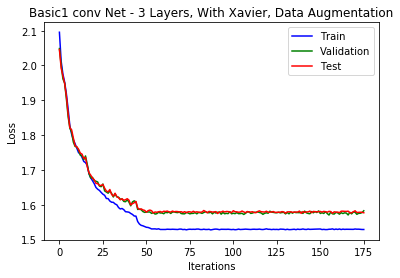

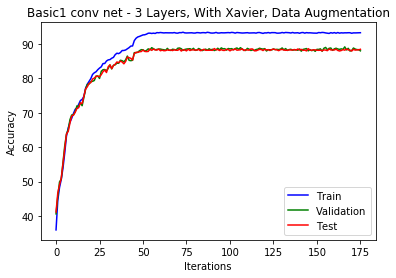

In [16]:
model = ModelTrainer(optim.Adam, nn.CrossEntropyLoss(), BasicNet(startoutputdepth=128))
model.train()